# Federated Learning Applications to Wireless Networks - A Demonstration

Federated Learning (FL) has many advantages with applications to future wireless networks.
As a distributed learning technique, FL is very promising for IoT and fringe-devices where the environment is often bandwidth-limited and energy-efficiency is a premium.
In addition, the privacy of data collection and distribution is of growing concern with these devices maintaining sensitive information, such as real-time location data and even medical information.

In this demonstration we will examine the benefits of using FL to train Deep Neural Networks (DNNs) in application to wireless network systems.
Specifically, we will see that FL is applicable in the areas of:

- "Green" communications
- Low bandwidth environments
- Data privacy

To demonstrate the advantages of low-bandwidth, "green", and privacy-centric communication, we will build a Convolutional Neural Network (CNN) image classifier and train using FL techniques on the traditional CIFAR10 dataset. Each image within CIFAR10 is relatively large. If network devices were required to transmit these images to a centralized server for model training there would be considerable bandwidth overhead. As such, we will show that FL can be used to lower communication overhead by training localized models that only transmit model parameters instead of the raw data over the network. In addition, because the images themselves are not being transmitted this approach is privacy-centric by nature. The global model at the central server does not need to know the details of the data, only the outcome of each localized model.

## TOC

This demo is organized into the following sections:

- [Setup environment](#setup-environment)
- [Load CIFAR-10 dataset](#load-cifar-10-dataset)
- [Model Definition](#model-definition)
- [Training](#training)
  - [Traditional Network](#traditional-network)
  - [Federated Learning](#federated-learning)
- [Results](#results)

## Setup environment

In [ ]:
import os

In [ ]:
workspace_root = '/fl-demo-workspace'
data_path = os.path.join(workspace_root, 'data')

## Load CIFAR-10 dataset

The CIFAR-10 dataset is a collection of $60,000$ images of size $32\times32$ and $3$ color channels that are split into 10 different classes.

The classes are represented by the set: $c \in \{'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'\}$

In [ ]:
import torch.utils.data
import torchvision
import torchvision.transforms as transforms

In [ ]:
# Define label list (indices are important!)
labels_cifar10 = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
# Define CIFAR10 image transformations for train/test sets.
transform_train_cifar10 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test_cifar10 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [ ]:
# Automatically load CIFAR10 dataset into train/test sets.
trainset_cifar10 = torchvision.datasets.CIFAR10(root=data_path, train=True, download=True, transform=transform_train_cifar10)
testset_cifar10 = torchvision.datasets.CIFAR10(root=data_path, train=False, download=True, transform=transform_test_cifar10)


Extracting /fl-demo-workspace/data/cifar-10-python.tar.gz to /fl-demo-workspace/data
Files already downloaded and verified


In [ ]:
# Define data loaders for train/test sets.
trainloader_cifar10 = torch.utils.data.DataLoader(trainset_cifar10, batch_size=64, shuffle=True, num_workers=2)
testloader_cifar10 = torch.utils.data.DataLoader(testset_cifar10, batch_size=100, shuffle=True, num_workers=2)

## Model Definition

In [ ]:
import torch
import torch.nn
import torch.optim

In [ ]:
class CIFAR10Classifier(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Define block of convolution/max-pool layers.
        self.block_cnn = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), padding=1), # 3x32x32 --> 32x32x32
            torch.nn.BatchNorm2d(num_features=32),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=(2,2), stride=2), # 32x32 --> 16x16
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1), # 32x16x16 --> 64x16x16
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding=1), # 64x16x16 --> 128x16x16
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.ReLU(inplace=True),
        )

        # Define block of fully-connected output layers.
        in_features = 128*16*16
        self.block_linear = torch.nn.Sequential(
            torch.nn.Linear(in_features=in_features, out_features=10),
        )

    def forward(self, x):

        # Feed input through sequential CNN/MaxPool layers.
        out = self.block_cnn(x)

        # Reshape CNN-block output to fit into linear-block.
        # Reshapes into: (batches, channels, width, height) --> (batches, channels * width * height)
        out = out.view(out.size(0), -1)

        # Feed reshaped CNN-block output into linear-block.
        out = self.block_linear(out) # outputs (batches, labels)

        # Apply softmax to get label for each prediction.
        return out

## Training

In [ ]:
import time
from contextlib import contextmanager

class timecontext:
    """Elapsed time context manager."""
    def __enter__(self):
        self.seconds = time.time()
        return self
    
    def __exit__(self, type, value, traceback):
        self.seconds = time.time() - self.seconds

@contextmanager
def timecontextprint(description='Elapsed time'):
    """Context manager to print elapsed time from call."""
    with timecontext() as t:
        yield t
    print(f"{description}: {t.seconds} seconds")

In [ ]:
def compute_model_accuracy(model, loader, device='cpu'):
    """Compute accuracy of a model for a given dataset loader."""
    model.to(device)
    model.eval()
    ys, y_preds = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            ys.append(y)
            y_preds.append(torch.argmax(model(x), dim=1))
    
    y = torch.cat(ys, dim=0).float()
    y_pred = torch.cat(y_preds, dim=0).float()
    return (y_pred == y).sum().float()/y.size(0)*100.0

### Traditional Network

Here we will traditionally train the CIFAR10 classifier on all the training data. We will then evaluate the performance of the model on the test data.

Traditional training involves evaluating a single model on a sequence of "training" data, where the desired outcomes are known. The losses of the computed output versus the actual values are then used to update the parameters of the model.

Specifically, the sequence of training operations for each epoch are:

1. Load a batch of training data
2. Zero the model parameter gradients
3. Evaluate the model on the training data inputs
4. Compare the evaluation result with the known truth
5. Back-propagate the comparison (a.k.a. "loss") through the network to update model parameters

In [ ]:
from typing import List
def train(model, loader, epoch, optim, criterion, device='cpu', verbose=True) -> List[float]:
    """Helper to train a single model.
    
    Returns a list of losses computed at each training epoch.
    """
    model.to(device) # Send model to desired device.
    model.train() # Put the model into training mode.
    losses = []
    for e in range(epoch):
        running_loss = 0.0
        for i, data in enumerate(loader):
            # unpack the data, and send data to desired device.
            inputs, labels = data[0].to(device), data[1].to(device)

            # Zero the parameter gradients.
            optim.zero_grad()

            # Evaluate the model.
            preds = model(inputs)

            # Compute losses.
            loss = criterion(preds, labels)

            # Back-propagate, and step the optimizer.
            loss.backward()
            optim.step()

            # Accumulate the loss for this epoch.
            running_loss += loss.item()

        # Report the loss per epoch if necessary.
        losses.append(running_loss)
        if verbose: print(f"[epoch {e}] loss: {running_loss}")

    # Return the list of loss.
    return losses

To speed-up training PyTorch allows us to leverage a GPU, using CUDA, if one is available. Since training a CNN can be computationally intensive we prefer to use a GPU for speed, but will revert to using the CPU if necessary.

In [ ]:
# Set runtime device.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [ ]:
# Define traditionally-trained singular model.
model_trad = CIFAR10Classifier()
model_trad_store = os.path.join(workspace_root, 'model_trad.pt')

Here we define a set of training learning parameters. We define the number of training epochs `epochs_trad` (i.e., the number of times the model is evaluated on the training data) and the learning rate `lr_trad` which defines the step size of the optimizer.

In [ ]:
# Learning hyperparameters.
epochs_trad = 10
lr_trad = 1e-3

In this block we actually perform the traditional training.

We choose the `Adam` parameter optimzer, which is widely used in practice, and `CrossEntropyLoss` which is useful for training classification models with a discrete set of classes.

At every training epoch the running loss will be reported. This helps us get a sense for how the model is learning. Ideally we want to see decreasing loss over all the epochs. Recall that loss is the comparison between the model predicitons versus the actual values. So, low losses mean the predictions are very close to the actual values.

To speed-up subsequent runs, we also save the trained model to a file. This allows us to train the traditional model once, and then simply load the pre-trained model (using the flag `load_from_file`) if the Jupyter notebook is run multiple times during a session.

In [ ]:
load_from_file = False

# Load model from store file.
if load_from_file and os.path.exists(model_trad_store):
    losses_trad = [] # No losses.
    model_trad.load_state_dict(torch.load(model_trad_store))
    print(f'Loaded traditional model from file: {model_trad_store}')

# Train model.
else:
    print(f'Training traditional model: epoch={epochs_trad}, lr={lr_trad}')

    # Train the model.
    # Display training time too.
    with timecontextprint() as elapsed:
        optim = torch.optim.Adam(model_trad.parameters(), lr=lr_trad)
        criterion = torch.nn.CrossEntropyLoss(reduction='mean')
        losses_trad = train(model_trad, loader=trainloader_cifar10, epoch=epochs_trad, optim=optim, criterion=criterion, device=device)

    # Store model state to file.
    torch.save(model_trad.state_dict(), model_trad_store)
    print(f'Saved traditional model to file: {model_trad_store}')

Training traditional model: epoch=10, lr=0.001
[epoch 0] loss: 1231.5566728711128
[epoch 1] loss: 700.9368018507957
[epoch 2] loss: 570.169086009264
[epoch 3] loss: 473.5074228942394
[epoch 4] loss: 392.38825093209743
[epoch 5] loss: 313.11588002741337
[epoch 6] loss: 241.79489093273878
[epoch 7] loss: 179.6480420716107
[epoch 8] loss: 137.25577499344945
[epoch 9] loss: 110.7554190941155
Elapsed time: 130.76434683799744 seconds
Saved traditional model to file: /fl-demo-workspace/model_trad.pt


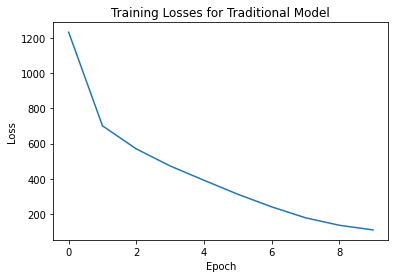

In [ ]:
import matplotlib.pyplot as plt
if losses_trad:
    plt.plot(losses_trad)
    plt.title('Training Losses for Traditional Model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

Now we evaluate the traditionally-trained model on both the training data and the testing data. This summarizes the performance of the model after training and allows us to see how well our model is able to "generalize" on unseen data.

You should see a training accuracy of about 95% and a testing accuracy of about 74%.

In [ ]:
# Evaluate the model.
train_acc_trad = compute_model_accuracy(model_trad, trainloader_cifar10, device=device)
test_acc_trad = compute_model_accuracy(model_trad, testloader_cifar10, device=device)
print(f'Training accuracy: {train_acc_trad}, Testing accuracy: {test_acc_trad}')

Training accuracy: 97.05400085449219, Testing accuracy: 73.92999267578125


In the cell below we compute the total size of the training image dataset (in bytes) and also compute the total size of the model parameters (in bytes).

In [ ]:
import sys
size_cifar10_train = sum(sys.getsizeof(img.storage()) + sys.getsizeof(lbl) for img,lbl in trainset_cifar10)
size_model_trad = sum(sys.getsizeof(p.storage()) for p in model_trad.parameters())
num_model_trad = sum(p.numel() for p in model_trad.parameters())
print(f"CIFAR10 train images total size: {size_cifar10_train:.4e} bytes")
print(f"Traditional model parameters: {num_model_trad} params, {size_model_trad:.4e} bytes")

CIFAR10 train images total size: 6.1938e+08 bytes
Traditional model parameters: 421386 params, 1.6866e+06 bytes


As you can see, the CIFAR training dataset in its entirety uncompressed is roughly 619.38 MB, wheras the model parameters themselves are only 1.68 MB. That's a space savings by roughly 368x!

Circling back on the applicability of DNNs and wireless networks we must examine the overhead necessary to train a model. Specifically, bandwidth and spectrum usage are of chief concern as highly valuable resources. Training this classificaiton model required the use of 50,000 training images, which as seen above weighs in at 619.38 MB in size. 

To traditionally train this model in a wireless network, the data would need to be collected from various devices and then transmitted over the network to a central server. These large data transfers are an inefficient use of resources and time consuming for low-bandwidth networks.

### Federated Learning

Here we will train another CIFAR10 image classifer, but this time we will use federated learning techniques to distribute the training.

In federated learning, we train a "global" model by aggregating the parameters of several "client" models. This technique distributes the computational complexity of training to multiple client devices and also mitigates the large-quantity data transfer as required by the traditional method. It does this by aggregating the parameters of each client model at regular update intervals.

The training steps in federated learning are actually very similar to the traditional case. The difference is that the client models are trained separately on their own local data. In practice this client-side training would be done asynchronously, but for the sake of limited computing resources in this demonstration we will be training the clients synchronously.

The technique behind federated learning lies in how the parameters of the client models are aggregated into the global model.

In cellular networks, speech vocoders save bandwidth by mathematically modeling speech bits using a set of parameters. These parameters are then transmitted over the network to reconstruct the speech signal rather than the actual speech bits themselves. Likewise, federated learning reduces the amount of data required to train the global model by **locally modeling the local data** (i.e., the client model) and then using the **local model parameters** to update the global model. These parameters are often much smaller in size than the amount of data used to train them and is thus more efficient in terms of communication overhead.

It is important to note that in federated learning only the client models actually undergo training. The global model only receives parameter aggregation updates from the clients and does not undergo any training itself.

There are many types of parameter aggregation methods (i.e. min, max, mean, weighted mean, etc.). The type to use varies depending on the modeling task at hand. In our case, the simple mean of the parameters will suffice.

In the code block below we define a global aggregation function `global_aggregate` which does the following:

1. Aggregates the parameters of several client models
2. Updates the parameters of a given global model to these aggregations
3. Synchronizes all client models to the new global model parameters

In [ ]:
from typing import List

def global_aggregate(global_model: torch.nn.Module, client_models: List[torch.nn.Module]):
    """Aggregate the parameters from several client models to a global model.

    The aggregation technique is the 'mean' of each parameter over all clients.
    """

    # Get current global model parameters.
    global_state_dict = global_model.state_dict()

    # Aggregate client model parameters using 'mean'.
    for key in global_state_dict.keys():
        global_state_dict[key] = torch.stack([client_models[i].state_dict()[key].float() for i in range(len(client_models))], dim=0).mean(dim=0)
    
    # Update the global model using aggregated parameters.
    global_model.load_state_dict(global_state_dict)

    # Finally, update each client's parameters to be the same as the global model.
    for model in client_models:
        model.load_state_dict(global_state_dict)

Here we define the hyperparameters of the federated learning technique. To keep the comparison with traditional model fair we will train the "global" model using the same number of epochs (in this case called a "round"). Likewise, each client model will be trained using the same number of epochs. This way each client is trained, and the global model is updated, the same number of times as the traditional model.

The number of clients to use here is representative of a wireless network of devices.

In [ ]:
# Federated learning hyper-parameters.
n_clients = 20 # Number of client models.
n_rounds = 10 # Number of training aggregation rounds.
epochs_fl = 10 # Number of training epochs for each client.
lr_fl = 1e-3 # Client optimizer learning rate.

Next we define the global and client models, and initially synchronize their parameter values (important in the case of random value initialization).

We then define a set of parameter optimizers for each of the client models and a common loss criterion. It is important to note that we are using the same `Adam` optimizer and `CrossEntropyLoss` criterion methods as in the traditional training case to fairly evaluate the performance at the end.

In [ ]:
# Define the global model.
model_fl_global = CIFAR10Classifier()

# Define client models
model_fl_clients = [CIFAR10Classifier() for _ in range(n_clients)]

# Initially synchronize clients to the global model.
for model in model_fl_clients:
    model.load_state_dict(model_fl_global.state_dict())

# Define training optimizers for each client model.
optimizers_fl = [torch.optim.Adam(model.parameters(), lr=lr_fl) for model in model_fl_clients]

# Define training criteria.
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

We do not want to train all the clients on the same data, which would introduce heavy bias into the model. To mitigate this with our CIFAR10 dataset we can split the training data randomly into equal-length sets amongst the clients so that there is no overlap.

In [ ]:
# Split dataset amongst clients so that no training data overlaps.
trainset_cifar10_fl_len = trainset_cifar10.data.shape[0]//n_clients
trainset_cifar10_fl_splits = torch.utils.data.random_split(trainset_cifar10, lengths=[trainset_cifar10_fl_len]*n_clients)

# Create data loaders for each client, which iterates over each split.
trainset_cifar10_fl_loaders = [torch.utils.data.DataLoader(split, batch_size=32, shuffle=True) for split in trainset_cifar10_fl_splits]

Now it is time to actually train the global model using federated learning. For each aggregation round each client model is trained using its own unique training dataset using exactly the same training steps as in the traditional case, calling the `train` function. Once each client has been trained the parameters from all clients are aggregated into the global model and then synchronized back to each client using the `global_aggregate` function. The losses from each client training session, the running loss for each aggregation round, and the overall training and testing accuracy of the global model are reported to get a sence of how the various models are learning.

In [ ]:
import numpy as np
from collections import defaultdict

# Run training/aggregation rounds.
losses_fl_clients = defaultdict(list)
for round in range(n_rounds):

    with timecontext() as t_round:
        loss_round = 0.0
        for c in range(n_clients):
            with timecontext() as t_client:
                losses = train(model_fl_clients[c],
                    loader=trainset_cifar10_fl_loaders[c],
                    epoch=epochs_fl,
                    optim=optimizers_fl[c],
                    criterion=criterion,
                    device=device,
                    verbose=False,
                )
                losses_fl_clients[c].append(losses)
                loss_round += losses[0]
            print(f"[round {round}] client: {c}, loss: {losses[0]}, elapsed: {t_client.seconds} seconds")
    print(f"[round {round}] loss: {loss_round}, elapsed: {t_round.seconds} seconds")

    # Aggregate the parameters for each model to the global one.
    global_aggregate(model_fl_global, model_fl_clients)

    # Evaluate the global model.
    train_acc_fl = compute_model_accuracy(model_fl_global, trainloader_cifar10, device=device)
    test_acc_fl = compute_model_accuracy(model_fl_global, testloader_cifar10, device=device)
    print(f'[round {round}] Training accuracy: {train_acc_fl}, Testing accuracy: {test_acc_fl}')

[round 0] client: 0, loss: 315.1113278865814, elapsed: 7.648017406463623 seconds
[round 0] client: 1, loss: 288.6881811618805, elapsed: 7.590365886688232 seconds
[round 0] client: 2, loss: 321.2861787080765, elapsed: 7.579125881195068 seconds
[round 0] client: 3, loss: 292.94701409339905, elapsed: 7.60521936416626 seconds
[round 0] client: 4, loss: 308.97459161281586, elapsed: 7.710943937301636 seconds
[round 0] client: 5, loss: 309.9500527381897, elapsed: 7.568099021911621 seconds
[round 0] client: 6, loss: 307.8862329721451, elapsed: 7.682716608047485 seconds
[round 0] client: 7, loss: 273.45854234695435, elapsed: 7.610569477081299 seconds
[round 0] client: 8, loss: 289.54146671295166, elapsed: 7.664233684539795 seconds
[round 0] client: 9, loss: 305.8398172855377, elapsed: 7.404385805130005 seconds
[round 0] client: 10, loss: 337.8761034011841, elapsed: 7.653854846954346 seconds
[round 0] client: 11, loss: 328.48791575431824, elapsed: 7.768931150436401 seconds
[round 0] client: 12, 

In [ ]:
# Compute average losses for each round.
losses_fl_clients_np = np.array([losses for c,losses in losses_fl_clients.items()])
losses_fl_global_mean = losses_fl_clients_np.mean(axis=2).sum(axis=0)

Let's plot the traditional model losses versus the global federated model.

In [ ]:
from google.colab import files

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

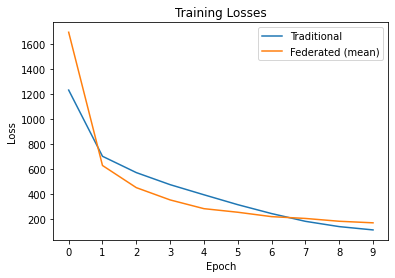

In [ ]:
if losses_trad:
    plt.plot(losses_trad, label='Traditional')
plt.plot(losses_fl_global_mean, label='Federated (mean)')
plt.xticks(np.arange(0,10,1))
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_tr_vs_fl.png', dpi=150, bbox_inches='tight')
files.download('loss_tr_vs_fl.png')

Let's also plot the accuracy of each of the client models.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

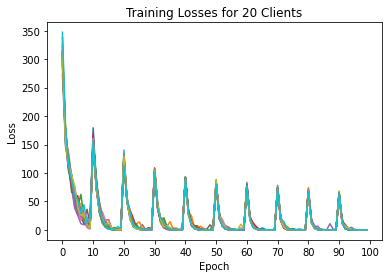

In [ ]:
for c,losses in enumerate(losses_fl_clients_np):
    plt.plot(losses.flatten(), label=f"Client {c}")
plt.xticks(np.arange(0,losses_fl_clients_np.shape[1]*losses_fl_clients_np.shape[2]+10, 10))
plt.title(f'Training Losses for {losses_fl_clients_np.shape[0]} Clients')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('loss_fl_clients.png', dpi=150, bbox_inches='tight')
files.download('loss_fl_clients.png')

## Results

Now let's take a look at how both models compare on the testing data. You will see that the two models are very close in performance.

In [ ]:
test_acc_fl = compute_model_accuracy(model_fl_global, testloader_cifar10, device=device)
test_acc_trad = compute_model_accuracy(model_trad, testloader_cifar10, device=device)
print(f"Traditional accuracy: {test_acc_trad}")
print(f"  Federated accuracy: {test_acc_fl}")

Traditional accuracy: 73.92999267578125
  Federated accuracy: 73.0199966430664


Recall before that the traditional model was trained using 50,000 images, comprising a size of roughly 619.38 MB. The following cell computes the total training size and model parameter size for each of the clients.

In [ ]:
# Compute total image training size for each client.
trainset_cifar10_fl_len
# print([len(split.indices) for split in trainset_cifar10_fl_splits])
# size_cifar10_train_fl = [sum(sys.getsizeof(img.storage()) + sys.getsizeof(lbl) for img,lbl in trainset_cifar10[split.indices]) for split in trainset_cifar10_fl_splits]
size_cifar10_train_fl = [sum(sys.getsizeof(trainset_cifar10[idx][0].storage()) + sys.getsizeof(trainset_cifar10[idx][1]) for idx in split.indices) for split in trainset_cifar10_fl_splits]
size_model_fl_clients = [sum(sys.getsizeof(p.storage()) for p in model.parameters()) for model in model_fl_clients]
size_model_fl_global = sum(sys.getsizeof(p.storage()) for p in model_fl_global.parameters())
print(f"Federated Learning model summary:")
print(f"\tGlobal Model: model_size={size_model_fl_global:.4e} bytes")
for c in range(n_clients):
    print(f"\tClient {c}: num_train_images={len(trainset_cifar10_fl_splits[c].indices)}, train_image_size={size_cifar10_train_fl[c]:.4e} bytes, model_size={size_model_fl_clients[c]:.4e} bytes")

Federated Learning model summary:
	Global Model: model_size=1.6866e+06 bytes
	Client 0: num_train_images=2500, train_image_size=3.0969e+07 bytes, model_size=1.6866e+06 bytes
	Client 1: num_train_images=2500, train_image_size=3.0969e+07 bytes, model_size=1.6866e+06 bytes
	Client 2: num_train_images=2500, train_image_size=3.0969e+07 bytes, model_size=1.6866e+06 bytes
	Client 3: num_train_images=2500, train_image_size=3.0969e+07 bytes, model_size=1.6866e+06 bytes
	Client 4: num_train_images=2500, train_image_size=3.0969e+07 bytes, model_size=1.6866e+06 bytes
	Client 5: num_train_images=2500, train_image_size=3.0969e+07 bytes, model_size=1.6866e+06 bytes
	Client 6: num_train_images=2500, train_image_size=3.0969e+07 bytes, model_size=1.6866e+06 bytes
	Client 7: num_train_images=2500, train_image_size=3.0969e+07 bytes, model_size=1.6866e+06 bytes
	Client 8: num_train_images=2500, train_image_size=3.0969e+07 bytes, model_size=1.6866e+06 bytes
	Client 9: num_train_images=2500, train_image_size

From the above we see that each client model was trained using 2500 images, with a total training size of roughly 30.97 MB. We also see that, like the traditional model, the parameters for each client model comprises a size of 1.68 MB. This is very promising as the federated model was trained using far less communication resources during each aggregation step (i.e., each client only transmits 1.68 MB instead of 30.97 MB).

Using federated learning we have dramatically reduced the amount of data required to train the global model at each epoch step. By distributing the training amongst client models, each client only needs to transmit 1.68 MB worth of parameters to be aggregated. This is ideal for low-bandwidth environments, and could be decreased further if compression techniques are performed.

This is also an excellent example data privacy, because in federated learning none of the training data is exposed to the global model, and by extension other sibling clients as well.